# Faster RCNN Training Notebook

## Import Libraries

In [1]:
import os, sys
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(BASE_DIR)

from src.models.Detection.Faster_RCNN import Faster_RCNN
from src.dataset.bdd_detetcion import BDDDetection
from src.config.defaults import cfg
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import SimpleProfiler
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from src.utils.DataLoaders import get_loader

## Load Datasets and DataLoaders

In [2]:
obj_cls = ['__bgr__', 'pedestrian', 'car', 'rider', 'bicycle', 'motorcycle', 'truck', 'bus']
cfg.DATASET.ROOT = 'BDD100K'
cfg.DATASET.IMAGE_ROOT = 'images/bdd100k/images/100k'

In [3]:
bdd_train_params = {
    'cfg': cfg,
    'stage': 'train',
    'relative_path': '../..',
    'obj_cls': obj_cls
}

bdd_train = BDDDetection(**bdd_train_params)

100%|█████████████████████████████████████████████████████████████████████████| 69863/69863 [00:03<00:00, 20083.20it/s]


In [4]:
bdd_val_params = {
    'cfg': cfg,
    'stage': 'val',
    'relative_path': '../..',
    'obj_cls': obj_cls
}

bdd_val = BDDDetection(**bdd_val_params)

100%|█████████████████████████████████████████████████████████████████████████| 69863/69863 [00:04<00:00, 17451.46it/s]


In [ ]:
bdd_test_params = {
    'cfg': cfg,
    'stage': 'test',
    'relative_path': '../..',
    'obj_cls': obj_cls
}

bdd_test = BDDDetection(**bdd_test_params)

In [ ]:
print(f"Trainig Images: {len(bdd_train)}. Validation Images: {len(bdd_val)}, Testing Images: {len(bdd_test)}")

In [5]:
train_dataloader_args = {
    'dataset': bdd_train,
    'batch_size': 1,
    'shuffle': True,
    'collate_fn': bdd_train.collate_fn,
    'pin_memory': True,
    'num_workers': 3
}
train_dataloader = get_loader(**train_dataloader_args)

val_dataloader_args = {
    'dataset': bdd_val,
    'batch_size': 1,
    'shuffle': False,
    'collate_fn': bdd_train.collate_fn,
    'pin_memory': True,
    'num_workers': 3
}
val_dataloader = get_loader(**val_dataloader_args)

test_dataloader_args = {
    'dataset': bdd_test,
    'batch_size': 1,
    'shuffle': False,
    'collate_fn': bdd_train.collate_fn,
    'pin_memory': True,
    'num_workers': 3
}
test_dataloader = get_loader(**test_dataloader_args)

"\ntrain_dataloader_args = {\n    'dataset': bdd_train,\n    'batch_size': 1,\n    'shuffle': True,\n    'collate_fn': bdd_train.collate_fn\n}\ntrain_dataloader = get_loader(**train_dataloader_args)\n\nval_dataloader_args = {\n    'dataset': bdd_val,\n    'batch_size': 1,\n    'shuffle': False,\n    'collate_fn': bdd_train.collate_fn\n}\nval_dataloader = get_loader(**val_dataloader_args)\n"

## Load Faster RCNN Model

In [6]:
faster_rcnn_params = {
    'cfg': cfg,
    'num_classes': len(bdd_train.cls_to_idx),
    'backbone': 'resnet50',
    'learning_rate': 1e-5,
    'weight_decay': 1e-3,
    'pretrained': True,
    'pretrained_backbone': True,
    'checkpoint_path': None,
}
model = Faster_RCNN(**faster_rcnn_params)

## Model Summary

In [7]:
ModelSummary(model)  

    | Name                                      | Type                     | Params
-----------------------------------------------------------------------------------------
0   | metric                                    | MeanAveragePrecision     | 0     
1   | model                                     | FasterRCNN               | 43.3 M
2   | model.transform                           | GeneralizedRCNNTransform | 0     
3   | model.backbone                            | BackboneWithFPN          | 26.9 M
4   | model.backbone.body                       | IntermediateLayerGetter  | 23.5 M
5   | model.backbone.body.conv1                 | Conv2d                   | 9.4 K 
6   | model.backbone.body.bn1                   | BatchNorm2d              | 128   
7   | model.backbone.body.relu                  | ReLU                     | 0     
8   | model.backbone.body.maxpool               | MaxPool2d                | 0     
9   | model.backbone.body.layer1                | Sequential          

## Training Section

### Find best batch size for this machine

In [10]:
# trainer = Trainer(accelerator='gpu', auto_scale_batch_size="binsearch", max_epochs=100)

In [11]:
# Find the batch size
# trainer.tune(model)

In [12]:
# model.batch_size

### Find the best learning rate

In [13]:
trainer = Trainer(accelerator='gpu', max_epochs=50, default_root_dir="../checkpoints/detection/FasterRCNN")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
lr_finder = trainer.tuner.lr_find(model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=86` reached.
LR finder stopped early after 86 steps due to diverging loss.
Restoring states from the checkpoint path at ..\checkpoints\detection\FasterRCNN\.lr_find_981b1e7d-ca70-4400-b860-548535a525ba.ckpt


C:\Users\local_adcm114\Temp\ipykernel_13908\1529364680.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


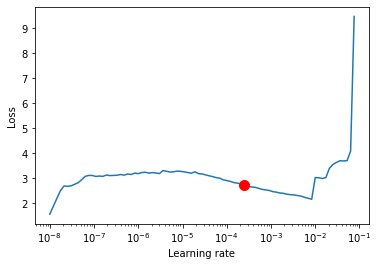

In [15]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [17]:
new_lr = lr_finder.suggestion()

In [18]:
model.learning_rate = new_lr

In [19]:
model.learning_rate

0.0002511886431509582

###  Sanity Check

In [20]:
"""
# use only 5% of training data and 1% of val data
sanuty_check_params = {
    'accelerator':'gpu',
    'devices': 1,
    'limit_train_batches':0.05,
    'limit_val_batches':0.01,
    'max_epochs':1,
    'default_root_dir':"../checkpoints/detection/FasterRCNN"
}
trainer = Trainer(**sanuty_check_params)
"""

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# trainer.fit(model)

Missing logger folder: ..\checkpoints\detection\FasterRCNN\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params
------------------------------------------------
0 | metric | MeanAveragePrecision | 0     
1 | model  | FasterRCNN           | 43.3 M
------------------------------------------------
43.1 M    Trainable params
225 K     Non-trainable params
43.3 M    Total params
173.148   Total estimated model params size (MB)


### Training

In [ ]:
early_stop_params = {
    'monitor': "val_loss",
    'patience':5,
    'verbose':False,
    'mode':"min"
}

early_stop_callback = EarlyStopping(**early_stop_params)

checkpoint_params = {
    'monitor': "val_loss",
    'mode':'min',
    'every_n_train_steps': 0,
    'every_n_epochs': 1,
    'dirpath': '../checkpoints/detection/FasterRCNN/v1'
}
    
checkpoint_callback = ModelCheckpoint(**checkpoint_params)
# logger = TensorBoardLogger(save_dir='../checkpoints/detection/FasterRCNN', version=1, name="lightning_logs")
logger = CSVLogger(save_dir="../logs/FasterRCNN/v3/logs", name="fasterrcnn_v3")

training_params = {
    'resume_from_checkpoint': '../checkpoints/detection/FasterRCNN/v1/epoch=4-step=277110.ckpt',
    'profiler': "simple",
    "logger": logger,
    'accelerator':'gpu',
    'devices': 1,
    'max_epochs': 30,
    'callbacks': [early_stop_callback, checkpoint_callback],
}

trainer = Trainer(**training_params)

In [ ]:
fit_params = {
    'model': model,
    'train_dataloaders': train_dataloader,
    'val_dataloaders': val_dataloader,
    'ckpt_path': '../checkpoints/detection/FasterRCNN/v1/epoch=4-step=277110.ckpt',
}
trainer.fit(**fit_params)

In [ ]:
# checkpoint_callback.best_model_path

In [ ]:
# trainer.logged_metrics  

In [ ]:
# trainer.logger.experiment

In [ ]:
# trainer.save_checkpoint("../weights/FasterRCNN.ckpt")

## Prediction

In [ ]:
predict_model = Faster_RCNN.load_from_checkpoint('../weights/Faster RCNN/v1/FasterRCNN.ckpt')

In [ ]:
# Predict the result for the whole batch
trainer = Trainer()
predictions = trainer.predict(predict_model, test_dataloader)

In [ ]:
# Predict the result for one batch only (one image)
batch = next(iter(test_dataloader))
prediction = predict_model.predict_step(batch)
print(prediction)